In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from step import msn, anba, util
from step import stats as st
from step import preprocessing as pp

import gpxpy
import pandas as pnd
import numpy as np
from datetime import timedelta
from tabulate import tabulate
import copy
import itertools

from scipy import stats

from sklearn import preprocessing
import statsmodels.api as sm

from math import cos, radians

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

sns.set_style('ticks', {'axes.titlesize': 'large', 'legend.frameon': True});

%load_ext autoreload
%autoreload 2

%matplotlib notebook
matplotlib.rcParams['axes.labelsize'] = 'large'
matplotlib.rcParams['ytick.labelsize'] = 'medium'
matplotlib.rcParams['xtick.labelsize'] = 'medium'
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['legend.fancybox'] = True
matplotlib.rcParams['legend.edgecolor'] = 'black'
matplotlib.rcParams['legend.framealpha'] = 1.0
matplotlib.rcParams['legend.fontsize'] = 'small'
matplotlib.rcParams['legend.markerscale'] = 0.8
matplotlib.rcParams['figure.figsize'] = (9, 3)
matplotlib.rcParams['axes.xmargin'] = 0.01
matplotlib.rcParams['axes.ymargin'] = 0.01
matplotlib.rcParams['axes.titlesize'] = 'large'
matplotlib.rcParams['figure.max_open_warning'] = 100

In [2]:
_1 = r'C:\DATA\MapMyRun\Grenoble\40890583\16_16_Run _ Jog\950590555.gpx'
_2 = r'C:\DATA\MapMyRun\Grenoble\37695677\16_16_Run _ Jog\1007756961.gpx'
_3 = r'C:\DATA\MapMyRun\Grenoble\49996348\16_16_Run _ Jog\1079694145.gpx'
_4 = r'C:\DATA\MapMyRun\Grenoble\27031614\16_283_Easy _ General\1223879101.gpx'
_7 = r'C:\DATA\MapMyRun\Grenoble\27031614\16_16_Run _ Jog\728010151.gpx'
_25 = r'C:\DATA\MapMyRun\Barcelona\54155702\16_103_Sprints\835097087.gpx'
_14 = r'C:\DATA\MapMyRun\Barcelona\54594328\16_16_Run _ Jog\1001316367.gpx'
_31 = r'C:\DATA\MapMyRun\Barcelona\40597477\16_16_Run _ Jog\1100430165.gpx'
_32 = r'C:\DATA\MapMyRun\Grenoble\38534723\16_16_Run _ Jog\998898403.gpx'
_33 = r'C:\DATA\MapMyRun\Grenoble\27031614\11_637_Commute\1583713025.gpx'
_34 = r'C:\DATA\MapMyRun\Grenoble\27031614\16_16_Run _ Jog\1416690011.gpx'
_36 = r'C:\DATA\MapMyRun\Grenoble\9909216\16_16_Run _ Jog\709085461.gpx'
_37 = r'C:\DATA\MapMyRun\Grenoble\40890583\16_16_Run _ Jog\1145927101.gpx'

_40 = r'C:\DATA\MapMyRun\Chicago\22732467\16_16_Run _ Jog\1086077661.gpx' #no distance outlier, sequence of 'stops'
_41 = r'C:\DATA\MapMyRun\Chicago\35494281\16_16_Run _ Jog\995057635.gpx' #no outliers

_42 = r'C:\DATA\MapMyRun\Grenoble\12589350\16_16_Run _ Jog\836744489.gpx'

_43 = r'C:\DATA\MapMyRun\Grenoble\40890583\16_16_Run _ Jog\880741289.gpx' #problem
_44 = r'C:\DATA\MapMyRun\Grenoble\40890583\16_16_Run _ Jog\1201252019.gpx' #paa .99 anba .9, 3 segmts
_45 = r'C:\DATA\MapMyRun\Grenoble\49996348\16_16_Run _ Jog\1554232397.gpx' #71.000 km ??? gpx defect

_46 = r'C:\DATA\MapMyRun\Grenoble\22901617\16_16_Run _ Jog\902217427.gpx'

_47 = r'C:\DATA\MapMyRun\Grenoble\22901617\16_16_Run _ Jog\977010005.gpx'
_48 = r'C:\DATA\MapMyRun\Grenoble\27031614\16_283_Easy _ General\1202902043.gpx'
_49 = r'C:\DATA\MapMyRun\Grenoble\27031614\16_283_Easy _ General\1208172029.gpx'
_50 = r'C:\DATA\MapMyRun\Grenoble\49996348\16_16_Run _ Jog\1355231355.gpx'
_51 = r'C:\DATA\MapMyRun\Grenoble\27031614\16_283_Easy _ General\1208172029.gpx'

_52 = r'C:\DATA\MapMyRun\Grenoble\41837719\16_16_Run _ Jog\1758229736.gpx'

In [3]:
gpx = gpxpy.parse(open(_4, 'r'))
#Ignore first 30 seconds (to avoid GPS "time to first fix")
gpx = pp.discard(gpx, timedelta(seconds=30))

movement_attributes = pp.get_movement_attributes(gpx)
df_all = pnd.DataFrame(movement_attributes, index=movement_attributes['timestamp'])

df = df_all[1:]

i_series = pnd.Series(np.arange(len(df)), index=df.index).rename('idx')
df = pnd.concat([df, i_series], axis=1)

df.head()

,acceleration,angle,distance,duration,elevation,heading,latitude,longitude,speed,timestamp,idx
2015-10-24 13:58:26,-0.01,178.68,10.40,5,216,323,45.184716,5.737285,2.08,2015-10-24 13:58:26,0
2015-10-24 13:58:31,-0.09,128.28,10.09,5,216,324,45.184790,5.737209,2.02,2015-10-24 13:58:31,1
2015-10-24 13:58:40,0.11,120.17,10.90,9,217,16,45.184884,5.737247,1.21,2015-10-24 13:58:40,2
2015-10-24 13:58:46,-0.01,175.72,11.07,6,217,76,45.184909,5.737384,1.84,2015-10-24 13:58:46,3
2015-10-24 13:58:52,-0.06,176.94,10.65,6,217,71,45.184939,5.737513,1.78,2015-10-24 13:58:52,4


<IPython.core.display.Javascript object>


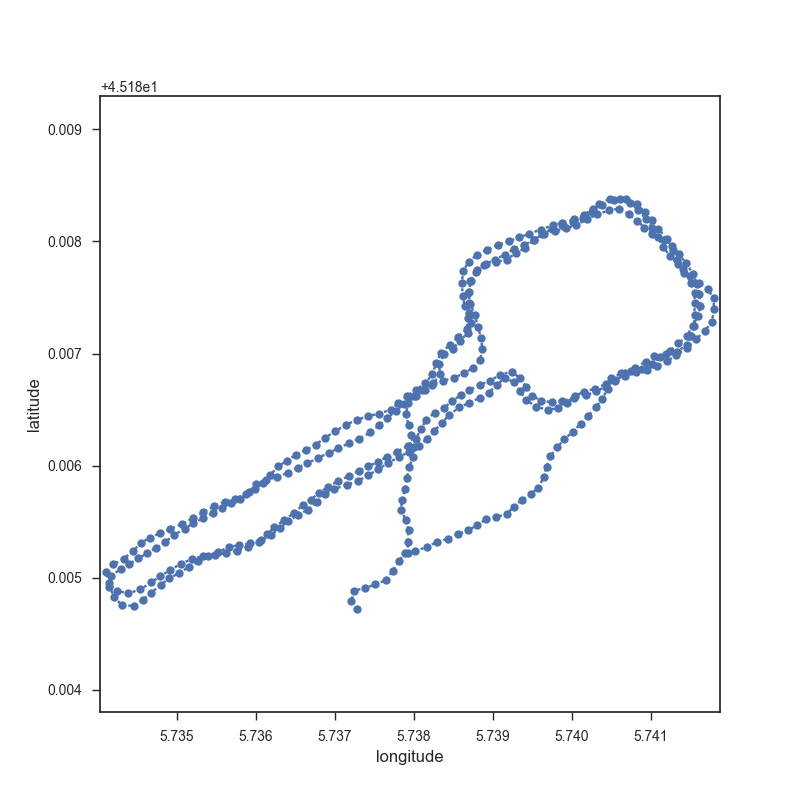

In [4]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

xx = df.longitude
yy = df.latitude

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.plot(df.longitude, df.latitude, 'o:', ms=6)

central_latitude = sum(plt.axes().get_ylim())/2.
mercator_aspect_ratio = 1/cos(radians(central_latitude))
plt.axes().set_aspect(mercator_aspect_ratio, adjustable='datalim')

In [5]:
moves, stops, noise = msn.get_move_stop_noise(df)
print('moves:', moves)
print('stops:', stops)
print('noise:', noise)

moves: [[0, 378]]
stops: []
noise: []


In [6]:
noise_indexes = msn.get_noise(df)
noise_indexes

array([], dtype=int32)

In [7]:
df.iloc[noise_indexes]

,acceleration,angle,distance,duration,elevation,heading,latitude,longitude,speed,timestamp,idx


In [8]:
df2 = df.drop(df.index[noise_indexes])
stop_indexes = msn.get_stops(df2)
stop_indexes

array([], dtype=int32)

In [9]:
df.iloc[stop_indexes]

,acceleration,angle,distance,duration,elevation,heading,latitude,longitude,speed,timestamp,idx


In [10]:
speed = df.speed[:]
speed[noise_indexes] = None
speed[stop_indexes] = 0

<IPython.core.display.Javascript object>


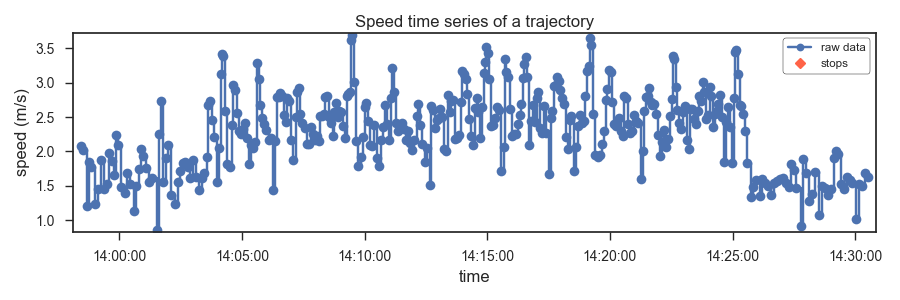

In [11]:
plt.figure()
plt.title("Speed time series of a trajectory")
plt.xlabel('time')
plt.ylabel('speed (m/s)')

plt.plot(speed, 'o-', label='raw data', drawstyle='steps-post');
plt.plot(speed[stop_indexes], 'D', label='stops', mew=1, color='tomato');
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.legend(frameon=True, loc='best')
plt.tight_layout()

In [12]:
data = df.speed[:]
data[noise_indexes] = None
data[stop_indexes] = 0

In [13]:
series = df.speed[:]

data = series.ewm(span=5).mean() #smoothed data
data[noise_indexes] = None
data[stop_indexes] = 0

<IPython.core.display.Javascript object>


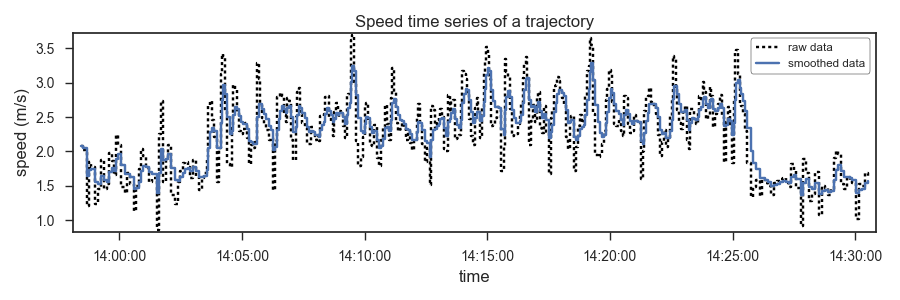

In [14]:
fig = plt.figure()
plt.title("Speed time series of a trajectory")
plt.xlabel('time')
plt.ylabel('speed (m/s)')

plt.plot(series, 'k:', label='raw data', drawstyle='steps-post')
plt.plot(data, '-', label='smoothed data', drawstyle='steps-post')

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.legend(frameon=True, loc='best')
plt.tight_layout()
#plt.savefig('figures/ts-smooth.png')

In [15]:
min_gvf = .5

In [16]:
gvf = 0.0
nclasses = 1
data_copy = np.copy(data.fillna(0))

while gvf < min_gvf:
    gvf = anba.goodness_of_variance_fit(data_copy, nclasses)
    nclasses += 1
    
nclasses

3

In [17]:
#nclasses = 2
breaks = anba.jenks(data_copy, nclasses)
breaks = np.sort(list(set(breaks)))
breaks

array([ 1.37240268,  1.95887946,  2.53787483,  3.2865754 ])

<IPython.core.display.Javascript object>


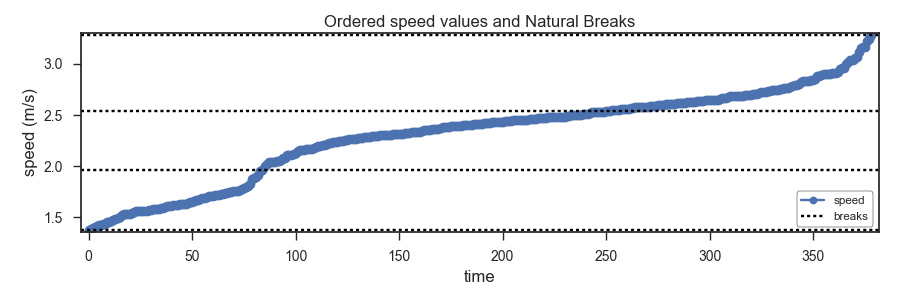

In [18]:
plt.figure()
plt.title("Ordered speed values and Natural Breaks")
plt.xlabel('time')
plt.ylabel('speed (m/s)')

plt.plot(data_copy, 'o-', alpha=1., label='speed', drawstyle='steps-post')
break_legend = True
for b in breaks:
    plt.axhline(b, label='breaks' if break_legend else "", linestyle=':', color='k')
    break_legend = False
    
plt.legend(frameon=True, loc=4)
plt.tight_layout()
#plt.savefig('figures/ts-sorted.png')

<IPython.core.display.Javascript object>


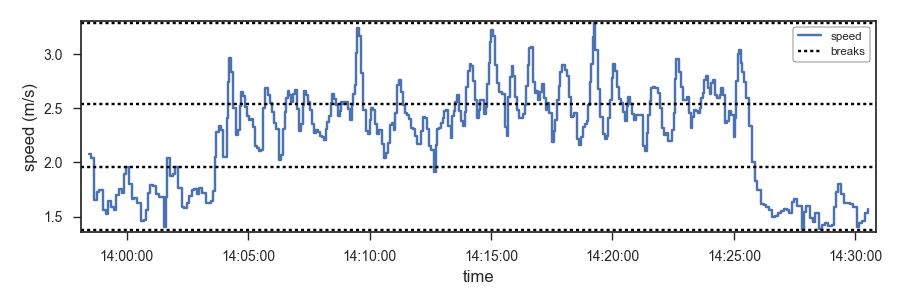

In [19]:
plt.figure()
#plt.title("Speed time series of a trajectory")
plt.xlabel('time')
plt.ylabel('speed (m/s)')

plt.plot(data, drawstyle='steps-post')

break_legend = True
for b in breaks:
    plt.axhline(b, label='breaks' if break_legend else "", linestyle=':', color='k')
    break_legend = False
    
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.legend(frameon=True, loc=1)
plt.tight_layout()
#plt.savefig('figures/ts-breaks.png')

In [20]:
diffs = np.diff(breaks)
groups = [[]] * nclasses

for d in data:
    for i, (break_, diff) in enumerate(zip(breaks, diffs)):
        if d >= break_ and d < break_+diff:
            groups[i] = np.append(groups[i], d)
            break
            
medians = np.nan_to_num([np.median(x) for x in groups])
medians = np.sort(medians)
medians

array([ 1.62042729,  2.3629319 ,  2.68776801])

<IPython.core.display.Javascript object>


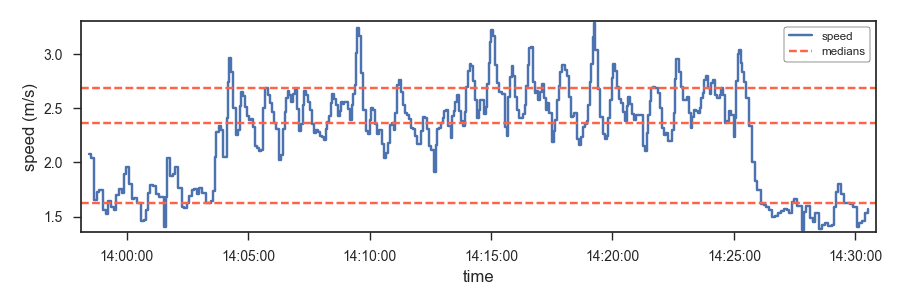

In [21]:
plt.figure()
#plt.title("Speed time series of a trajectory")
plt.xlabel('time')
plt.ylabel('speed (m/s)')

plt.plot(data, drawstyle='steps-post')

medians_legend = True
for m in medians:
    plt.axhline(m, label='medians' if medians_legend else "", linestyle='--', color='tomato')
    medians_legend = False
    
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.legend(frameon=True, loc='best')
plt.tight_layout()
#plt.savefig('figures/ts-medians.png')

<IPython.core.display.Javascript object>


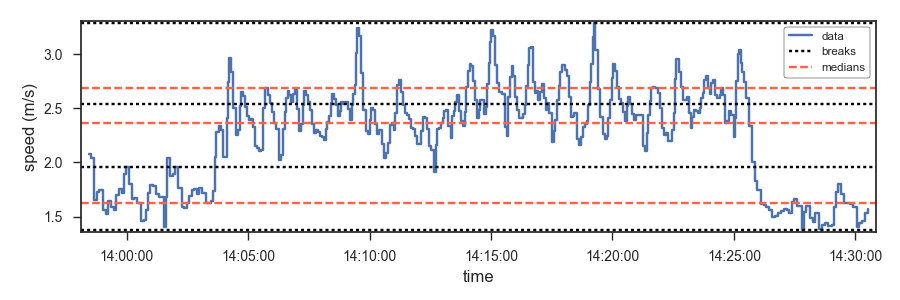

[ 1.37240268  1.95887946  2.53787483  3.2865754 ]
[ 1.62042729  2.3629319   2.68776801]


In [22]:
plt.figure()
#plt.title("Speed time series of a trajectory")
plt.xlabel('time')
plt.ylabel('speed (m/s)')

plt.plot(data, label='data', drawstyle='steps-post')

break_legend = True
for b in breaks:
    plt.axhline(b, label='breaks' if break_legend else "", linestyle=':', color='k')
    break_legend = False
    
medians_legend = True
for m in medians:
    plt.axhline(m, label='medians' if medians_legend else "", linestyle='--', color='tomato')
    medians_legend = False
    
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.legend(frameon=True, loc='best')
plt.tight_layout()
plt.savefig('figures/ts-breaks-medians.png')

print(breaks)
print(medians)

In [23]:
newgroups = [[]] * nclasses
newdata = []
bins = []

for d in data:
    absolute_distance = abs(d - medians)
    bin_index = np.argmin(absolute_distance)
    bins.append(bin_index)
    newgroups[bin_index] = np.append(newgroups[bin_index], [d], axis=0)
    newdata.append(medians[bin_index])
    
newdata = np.array(newdata)
data[stop_indexes] = 0
newdata[noise_indexes] = None
newdata = pnd.Series(newdata, index=data.index)

len(data), len(newdata)

(379, 379)

<IPython.core.display.Javascript object>


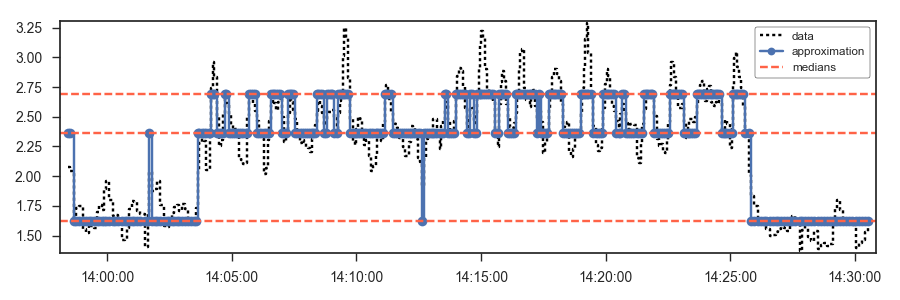

In [24]:
plt.figure()
#plt.title("Classified speed".format(min_gvf, nclasses))
plt.plot(data, 'k:', label='data', alpha=1., drawstyle='steps-post')
plt.plot(newdata, 'o-', label='approximation', drawstyle='steps-post');

medians_legend = True
for m in medians:
    plt.axhline(m, label='medians' if medians_legend else "", linestyle='--', color='tomato')
    medians_legend = False

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.legend(frameon=True, loc='best')
plt.tight_layout()

# Merge Medians

In [25]:
medians_diff = np.ediff1d(medians, to_begin=np.inf)

print('medians:', medians)
print('diff:', medians_diff)

min_diff = .5
mask = [True if d > min_diff and d < np.inf else False for d in np.ediff1d(medians, to_begin=np.inf)]
print(mask)

if any(mask):
    start = None
    end = None
    intervals = []
    for i, m in enumerate(mask):
        if m:
            if start is None:
                start = i
        else:
            if start is not None:
                end = i
                intervals.append([start, end])
                start = None
    print(intervals)
    newvalues = []
    oldvalues = []
    for interval in intervals:
        s = interval[0]  # start
        e = interval[1]  # end
        n = e - s + 1
        
        if n > 2:
            if (medians[e]-medians[s])//min_diff >= 2:
                print('>=2')
                newvalues.extend(np.arange(medians[s], medians[e], min_diff))
            elif medians[e]-medians[s] > min_diff:
                newvalues.extend([medians[s], medians[e]])
            else:
                newvalues.extend([medians[s], medians[s]+min_diff])
            
            #newvalues.extend(list(np.arange(medians[s], medians[e], min_diff)))
            oldvalues.extend(medians[s:e+1])
        elif n == 2:
            print('n==2')
            newvalues.extend([np.mean([medians[s], medians[e]])])
            oldvalues.extend(medians[s:e+1])
        else:
            print("Merge medians warning")

    print('old', oldvalues)
    print('new', newvalues)
    cleaned = [x for x in medians if x not in oldvalues]

    merged_medians = np.sort(np.append(cleaned, newvalues)) #######################
else:
    merged_medians = medians

merged_medians

medians: [ 1.62042729  2.3629319   2.68776801]
diff: [        inf  0.7425046   0.32483611]
[False, True, False]
[[1, 2]]
n==2
old [2.362931896503019, 2.6877680077197348]
new [2.5253499521113767]


array([ 1.62042729,  2.52534995])

<IPython.core.display.Javascript object>


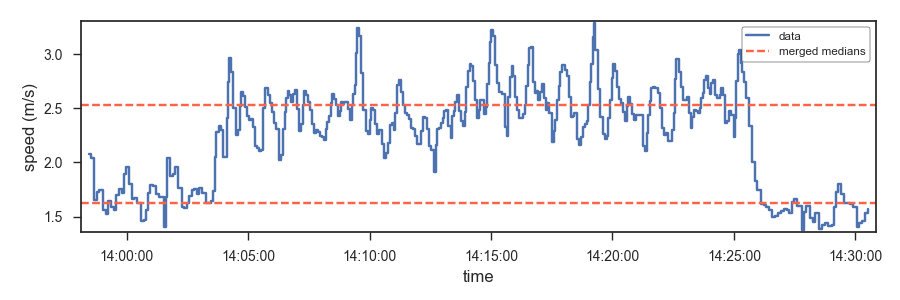

[ 1.62042729  2.52534995]


In [26]:
plt.figure()
#plt.title("Speed time series of a trajectory")
plt.xlabel('time')
plt.ylabel('speed (m/s)')

plt.plot(data, label='data', drawstyle='steps-post')

medians_legend = True
for m in merged_medians:
    plt.axhline(m, label='merged medians' if medians_legend else "", linestyle='--', color='tomato')
    medians_legend = False
    
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.legend(frameon=True, loc='best')
plt.tight_layout()
#plt.savefig('figures/ts-merged-medians.png')

print(merged_medians)

In [27]:
newgroups = [[]] * nclasses
newdata = []
bins = []

for i, d in enumerate(data):
    absolute_distance = abs(d - merged_medians)
    bin_index = np.argmin(absolute_distance)
    bins.append(bin_index)
    newgroups[bin_index] = np.append(newgroups[bin_index], [d], axis=0)
    newdata.append(merged_medians[bin_index])
    
newdata = np.array(newdata)
data[stop_indexes] = 0
newdata[noise_indexes] = None
newdata = pnd.Series(newdata, index=data.index)

data[stop_indexes] = 0
data.iloc[noise_indexes] = None                

newdata[stop_indexes] = 0
newdata.iloc[noise_indexes] = None 

<IPython.core.display.Javascript object>


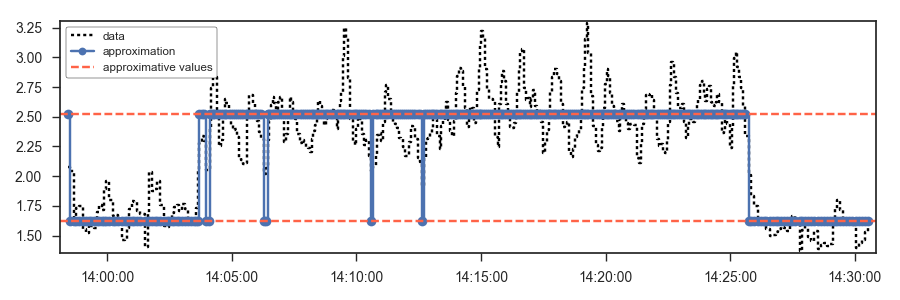

In [28]:
plt.figure()
plt.plot(data, 'k:', label='data', alpha=1., drawstyle='steps-post')
plt.plot(newdata, 'o-', label='approximation', drawstyle='steps-post');

medians_legend = True
for m in merged_medians:
    plt.axhline(m, label='approximative values' if medians_legend else "", linestyle='--', color='tomato')
    medians_legend = False

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.legend(frameon=True, loc='best')
plt.tight_layout()
#plt.savefig('figures/ts-anba-1.png')

In [29]:
#Mean Square Error
#Correlation 
# http://download.springer.com.gaelnomade.ujf-grenoble.fr/static/pdf/718/chp%253A10.1007%252F978-3-540-28651-6_77.pdf?originUrl=http%3A%2F%2Flink.springer.com%2Fchapter%2F10.1007%2F978-3-540-28651-6_77&token2=exp=1470404064~acl=%2Fstatic%2Fpdf%2F718%2Fchp%25253A10.1007%25252F978-3-540-28651-6_77.pdf%3ForiginUrl%3Dhttp%253A%252F%252Flink.springer.com%252Fchapter%252F10.1007%252F978-3-540-28651-6_77*~hmac=067e3dfea5286dfb49e7995f54861c4afda19fb816cb2acf00351fdb537ee4eb

In [30]:
time_threshold = np.percentile(df.duration, 90)
print('time threshold:', time_threshold)

change_points = util.get_change_points(newdata)

len(change_points) ,change_points

time threshold: 7.0


(13, array([  0,   1,  48,  51,  53,  80,  82, 137, 138, 162, 163, 338, 378]))

<IPython.core.display.Javascript object>


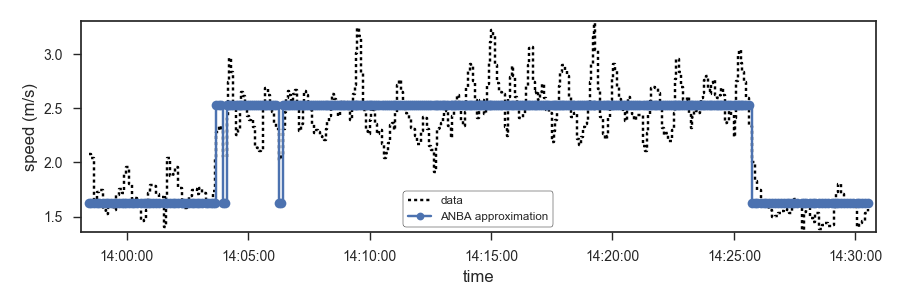

In [31]:
for i, (ch, d, date) in enumerate(zip(change_points, newdata[change_points], newdata.index[change_points])):
    if i == 0:
        continue

    prev_date = newdata.index[change_points[i-1]]
    diff = ch - change_points[i-1]
    time = (date - prev_date).seconds

    if diff <= 1 and time <= time_threshold and newdata[ch-1] > 0.0 and newdata[ch-1] != None:
        #print(ch-1, newdata[ch-1], diff, prev_date)
        if i < 2:
            left_neig = None
            right_neig = newdata[ch]
        else:
            left_neig = newdata[ch-2]
            right_neig = newdata[ch]
            
        #print('\tneighbors:', left_neig, right_neig)
        if right_neig:
            newdata[ch-1] = right_neig
        else:
            newdata[ch-1] = left_neig

plt.figure()
#plt.title("Speed time series of a trajectory")
plt.xlabel('time')
plt.ylabel('speed (m/s)')

plt.plot(data, 'k:', label='data', alpha=1., drawstyle='steps-post')
plt.plot(newdata, 'o-', label='ANBA approximation', drawstyle='steps-post');

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));

plt.legend(frameon=True, loc='best')
plt.tight_layout()

In [32]:
change_points = util.get_change_points(newdata)
len(change_points), change_points

(8, array([  0,  48,  51,  53,  80,  82, 338, 378]))

<IPython.core.display.Javascript object>


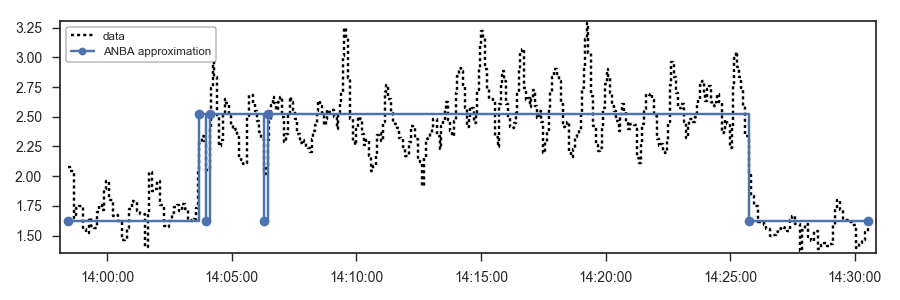

In [33]:
newdata_series = pnd.Series(newdata[change_points], index=newdata.index[change_points])

plt.figure()
plt.plot(data, 'k:', label='data', alpha=1., drawstyle='steps-post')
plt.plot(newdata_series, 'o-', label='ANBA approximation', drawstyle='steps-post')
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"))

plt.legend(frameon=True, loc='best')
plt.tight_layout()
#plt.savefig('figures/ts-anba-2.png')
plt.savefig('figures/ts-anba-without-merge.png')

In [34]:
running_time = {}

In [35]:
runtime = %timeit -o -n3 newdata = anba.anba(data, min_gvf=None, nclasses=nclasses, min_dist=0.5, min_time=time_threshold)
running_time.update({"anba n": [runtime.best]})

3 loops, best of 3: 546 ms per loop


In [36]:
runtime = %timeit -o -n3 newdata = anba.anba(data, min_gvf=0.5, nclasses=None, min_dist=0.5, min_time=time_threshold)
running_time.update({"anba gvf": [runtime.best]})

runtime

3 loops, best of 3: 1.23 s per loop


<TimeitResult : 3 loops, best of 3: 1.23 s per loop>

newdata = anba.anba(data, nclasses)

newdata[stop_indexes] = 0
newdata.iloc[noise_indexes] = None

In [37]:
mse_dict = {}
corr_dict = {}

In [38]:
mse = np.sqrt(((newdata - data) ** 2).mean())
corr = newdata_series.corr(data)

mse_dict.update({"anba": [mse]})
corr_dict.update({"anba": [corr]})

mse, corr

(0.22642231901731907, 0.76929759083629123)

In [39]:
n_segments = {}

In [40]:
n_segments.update({"anba": [len(change_points)-1]})
len(change_points)-1

7

In [41]:
min_gvf = .5
min_dist = 1
min_time = time_threshold

anba_data = anba.anba(data, min_gvf, None, min_dist, min_time)

rmse = np.sqrt(((anba_data - data) ** 2).mean())
correlation = anba_data.corr(data)
seg = len(util.get_change_points(anba_data))-1

rmse, correlation, seg

(0.41394689741739227, 0.69459675926854891, 13)

<IPython.core.display.Javascript object>


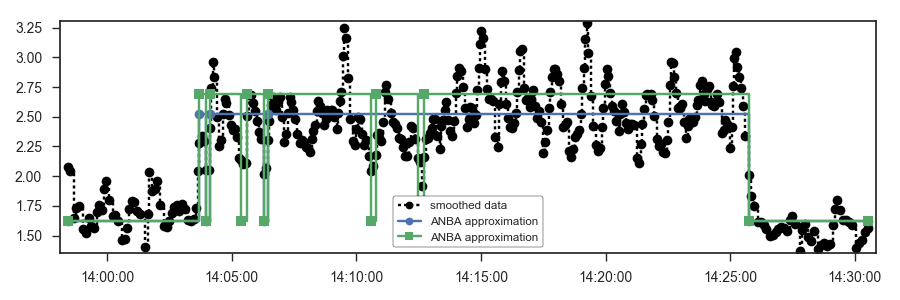

In [42]:
plt.figure()
plt.plot(data, 'ko:', label='smoothed data', drawstyle='steps-post')
plt.plot(newdata_series, 'o-', label='ANBA approximation', drawstyle='steps-post')
plt.plot(anba_data, 's-', label='ANBA approximation', drawstyle='steps-post')

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"))
plt.legend(frameon=True, loc='best')
plt.tight_layout()

In [43]:
print(len(anba_data))
len(newdata), len(data)

14


(379, 379)

# Comparison

In [44]:
#from preprocess.simplesegment import segment, fit
from simplesegment import segment, fit

In [45]:
def draw_plot(data,plot_title):
    plt.plot(range(len(data)), data, alpha=.5, color='red')
    plt.title(plot_title)
    plt.xlabel("Samples")
    plt.ylabel("Signal")
    plt.xlim((0,len(data)-1))
    
def draw_segments(segments):
    ax = plt.gca()
    for s in segments:
        line = plt.Line2D((s[0],s[2]),(s[1],s[3]), marker='o')#, drawstyle='steps-post')
        ax.add_line(line)
'''
def create_series(segments, data):
    pls = []
    for seg in segments:
        length = seg[2]-seg[0]
        #interpolated = np.linspace(seg[1], seg[3], length)
        median = data.iloc[seg[0]:seg[2]].median()
        interpolated = np.linspace(median, median, length)
        
        pls.extend(interpolated)
    
    if len(pls) < len(data):
        points_left = len(data) - len(pls)
        pls.extend(data[len(data)-points_left:])
        print('WARNING: create_series - original points appended:', points_left)
        
    pls = pnd.Series(pls, index=data.index)
    
    # reintroduce stops
    pls[data[data==0].index] = 0
    
    # reintroduce noise
    pls.iloc[noise_indexes] = None
    
    return pls
''' 
def create_series(segments, data):
    pls = []
    for seg in segments:
        length = seg[2] - seg[0]
        #interpolated = np.linspace(seg[1], seg[3], length)
        median = data.iloc[seg[0]:seg[2]].median()
        interpolated = np.linspace(median, median, length)
        pls.extend(interpolated)

    if len(pls) < len(data):
        points_left = len(data) - len(pls)
        pls.extend(data[len(data) - points_left:])
        print('WARNING: create_series - original points appended:', points_left)

    pls = pnd.Series(pls, index=data.index)

    # reintroduce stops
    pls[data[data == 0].index] = 0

    #reintroduce noise
    noise_indexes = [i for i, d in enumerate(data) if np.isnan(d)]
    pls[noise_indexes] = None

    return pls

In [46]:
max_error = 1
max_error

1

In [47]:
data_copy = data[:]
data_copy = data_copy.fillna(0)

## Sliding window with regression

In [48]:
segments = segment.slidingwindowsegment(data_copy, fit.regression, fit.sumsquared_error_regr, max_error)

<IPython.core.display.Javascript object>


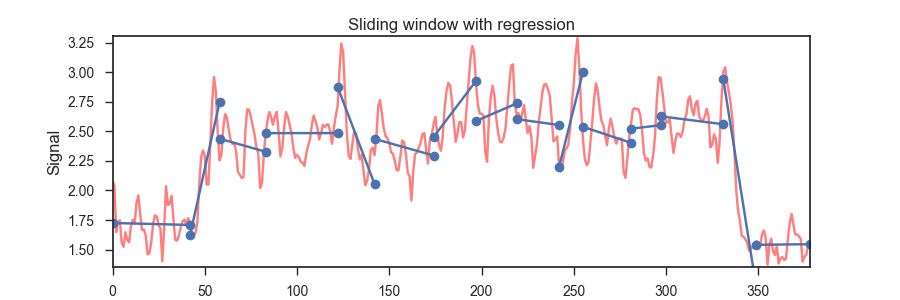

In [49]:
plt.figure()
draw_plot(data_copy, "Sliding window with regression")
draw_segments(segments)

In [50]:
new_segments = []
for s in segments:
    mean = np.mean([s[1], s[3]])
    new_segments.append([s[0], mean, s[2], mean])
    
new_series = create_series(new_segments, data)

In [51]:
change_points = util.get_change_points(new_series)
len(change_points), change_points

(16, array([  0,  42,  58,  83, 122, 142, 174, 197, 219, 242, 255, 281, 297,
        331, 349, 378]))

<IPython.core.display.Javascript object>


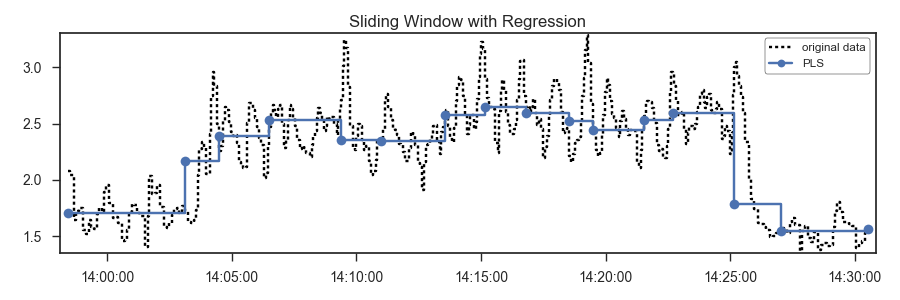

In [52]:
plt.figure()
plt.title("Sliding Window with Regression")
plt.plot(data, 'k:', label='original data', drawstyle='steps-post');
plt.plot(new_series[change_points], 'o-', label='PLS', drawstyle='steps-post')

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"))
plt.legend(frameon=True, loc='best')
plt.tight_layout()

In [53]:
mse = np.sqrt(((new_series - data) ** 2).mean())
corr = new_series[change_points].corr(data)

mse_dict.update({"sliding window \nwith regression": [mse]})
corr_dict.update({"sliding window \nwith regression": [corr]})

mse, corr

(0.25850110224954387, 0.6238190260779698)

In [54]:
change_points = util.get_change_points(new_series)
n_segments.update({"sliding window \nwith regression": [len(change_points)-1]})
len(change_points)-1

15

## Bottom-up with regression

In [55]:
segments = segment.bottomupsegment(data_copy, fit.regression, fit.sumsquared_error_regr, max_error)

<IPython.core.display.Javascript object>


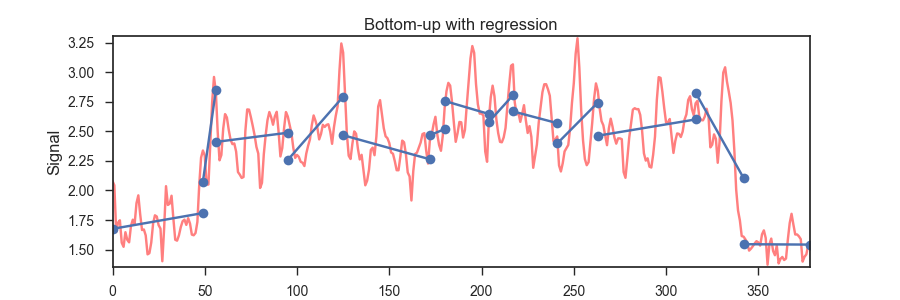

In [56]:
plt.figure()
draw_plot(data_copy,"Bottom-up with regression")
draw_segments(segments)

In [57]:
new_segments = []
for s in segments:
    mean = np.mean([s[1], s[3]])
    new_segments.append([s[0], mean, s[2], mean])
    
new_series = create_series(new_segments, data)

In [58]:
change_points = util.get_change_points(new_series)
len(change_points), change_points

(14,
 array([  0,  49,  56,  95, 125, 172, 180, 204, 217, 241, 263, 316, 342, 378]))

<IPython.core.display.Javascript object>


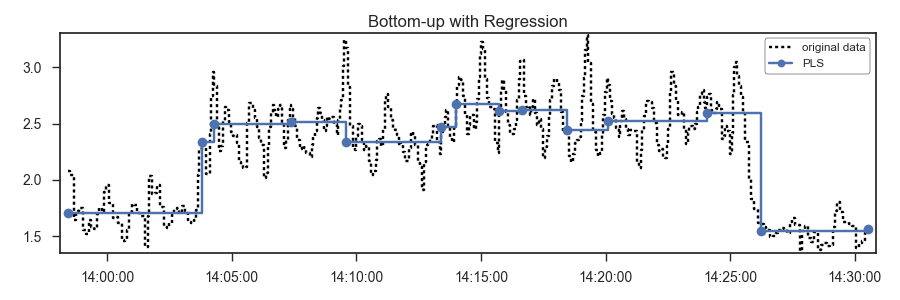

In [59]:
plt.figure()
plt.title("Bottom-up with Regression")
plt.plot(data, 'k:', label='original data', drawstyle='steps-post');
plt.plot(new_series[change_points], 'o-', label='PLS', drawstyle='steps-post');

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"))
plt.legend(frameon=True, loc='best')
plt.tight_layout()

In [60]:
mse = np.sqrt(((new_series - data) ** 2).mean())
corr = new_series[change_points].corr(data)

mse_dict.update({"bottom-up with \nregression": [mse]})
corr_dict.update({"bottom-up with \nregression": [corr]})

mse, corr

(0.22415816573295044, 0.85864061539942527)

In [61]:
change_points = util.get_change_points(new_series)
n_segments.update({"bottom-up with \nregression": [len(change_points)-1]})
len(change_points)-1

13

## Top-down with regression

In [62]:
segments = segment.topdownsegment(data_copy, fit.regression, fit.sumsquared_error_regr, max_error)

<IPython.core.display.Javascript object>


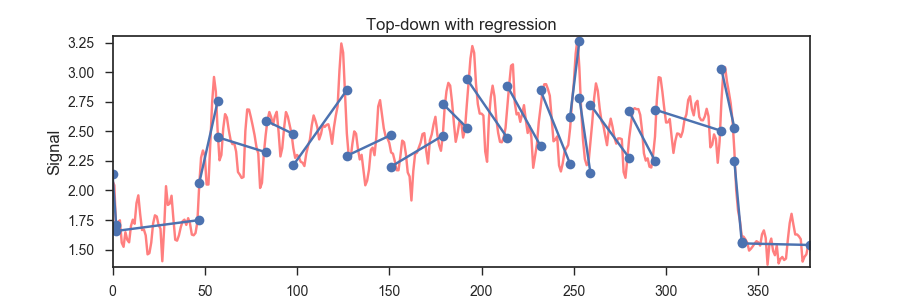

In [63]:
pls = create_series(segments, data)

plt.figure()
draw_plot(data_copy, "Top-down with regression")
draw_segments(segments)

In [64]:
new_segments = []
for s in segments:
    mean = np.mean([s[1], s[3]])
    new_segments.append([s[0], mean, s[2], mean])
    
new_series = create_series(new_segments, data)

In [65]:
change_points = util.get_change_points(new_series)
len(change_points), change_points

(21, array([  0,   2,  47,  57,  83,  98, 127, 151, 179, 192, 214, 232, 248,
        253, 259, 280, 294, 330, 337, 341, 378]))

<IPython.core.display.Javascript object>


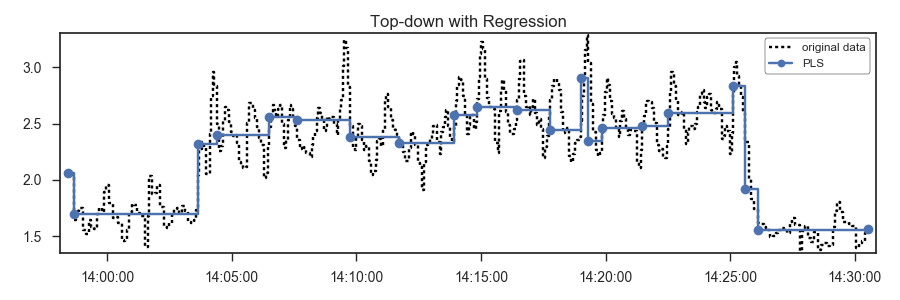

In [66]:
plt.figure()
plt.title("Top-down with Regression")
plt.plot(data, 'k:', label='original data', drawstyle='steps-post');
plt.plot(new_series[change_points], 'o-', label='PLS', drawstyle='steps-post');

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"))
plt.legend(frameon=True, loc='best')
plt.tight_layout()

In [67]:
mse = np.sqrt(((new_series - data) ** 2).mean())
corr = new_series[change_points].corr(data)

mse_dict.update({"top-down \nwith regression": [mse]})
corr_dict.update({"top-down \nwith regression": [corr]})

mse, corr

(0.19440591783525826, 0.81881886719498387)

In [68]:
change_points = util.get_change_points(new_series)
n_segments.update({"top-down \nwith regression": [len(change_points)-1]})
len(change_points)-1

20

## Sliding window with simple interpolation

In [69]:
segments = segment.slidingwindowsegment(data_copy, fit.interpolate, fit.sumsquared_error_int, max_error)

<IPython.core.display.Javascript object>


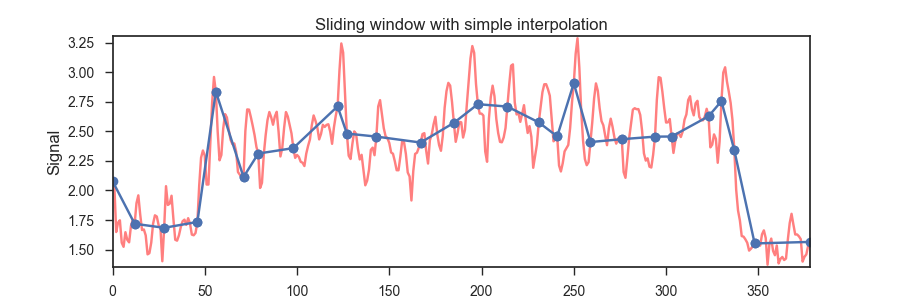

In [70]:
plt.figure()
draw_plot(data,"Sliding window with simple interpolation")
draw_segments(segments)

In [71]:
new_segments = []
for s in segments:
    mean = np.mean([s[1], s[3]])
    new_segments.append([s[0], mean, s[2], mean])
    
new_series = create_series(new_segments, data)

In [72]:
change_points = util.get_change_points(new_series)
len(change_points), change_points

(27, array([  0,  12,  28,  46,  56,  71,  79,  98, 122, 127, 143, 167, 185,
        198, 214, 231, 241, 250, 259, 276, 294, 303, 323, 330, 337, 348, 378]))

<IPython.core.display.Javascript object>


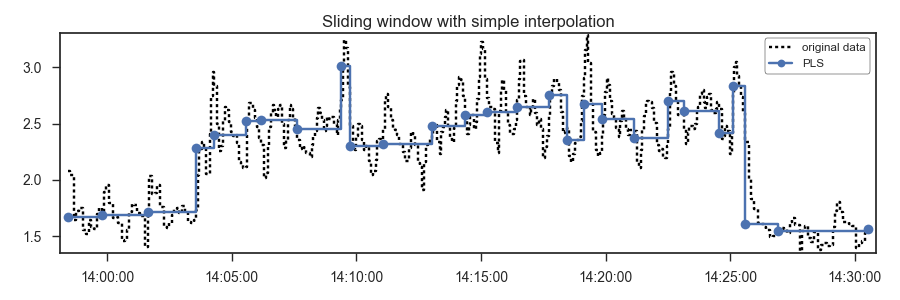

In [73]:
plt.figure()
plt.title("Sliding window with simple interpolation")
plt.plot(data, 'k:', label='original data', drawstyle='steps-post');
plt.plot(new_series[change_points], 'o-', label='PLS', drawstyle='steps-post');

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"))
plt.legend(frameon=True, loc='best')
plt.tight_layout()

In [74]:
mse = np.sqrt(((new_series - data) ** 2).mean())
corr = new_series[change_points].corr(data)

mse_dict.update({"sliding window with \nsimple interpolation": [mse]})
corr_dict.update({"sliding window with \nsimple interpolation": [corr]})

mse, corr

(0.19351768513587636, 0.78712772594321812)

In [75]:
change_points = util.get_change_points(new_series)
n_segments.update({"sliding window with \nsimple interpolation": [len(change_points)-1]})
len(change_points)-1

26

## Bottom-up with  simple interpolation

In [76]:
segments = segment.bottomupsegment(data_copy, fit.interpolate, fit.sumsquared_error_int, max_error)

<IPython.core.display.Javascript object>


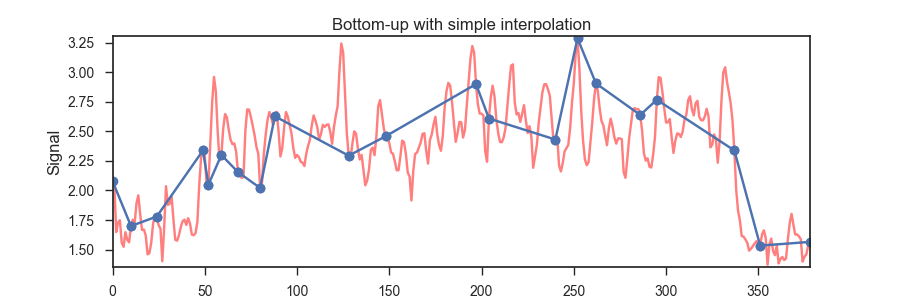

In [77]:
plt.figure()
draw_plot(data_copy, "Bottom-up with simple interpolation")
draw_segments(segments)

In [78]:
new_segments = []
for s in segments:
    mean = np.mean([s[1], s[3]])
    new_segments.append([s[0], mean, s[2], mean])
    
new_series = create_series(new_segments, data)

In [79]:
change_points = util.get_change_points(new_series)
len(change_points), change_points

(21, array([  0,  10,  24,  49,  52,  59,  68,  80,  88, 128, 148, 197, 204,
        240, 252, 262, 286, 295, 337, 351, 378]))

<IPython.core.display.Javascript object>


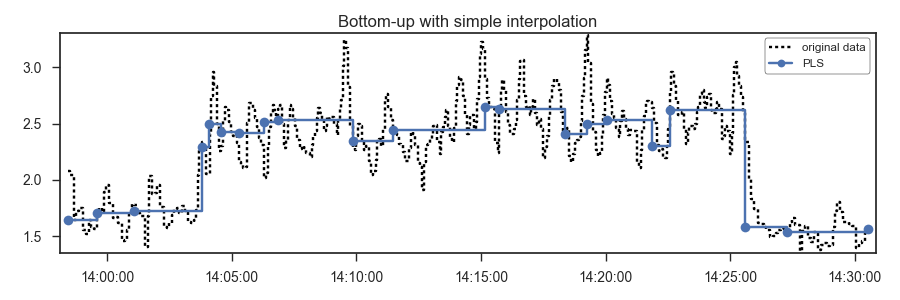

In [80]:
plt.figure()
plt.title("Bottom-up with simple interpolation")
plt.plot(data, 'k:', label='original data', drawstyle='steps-post');
plt.plot(new_series[change_points], 'o-', label='PLS', drawstyle='steps-post');

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"))
plt.legend(frameon=True, loc='best')
plt.tight_layout()

In [81]:
mse = np.sqrt(((new_series - data) ** 2).mean())
corr = new_series[change_points].corr(data)

mse_dict.update({"bottom-up with \nsimple interpolation": [mse]})
corr_dict.update({"bottom-up with \nsimple interpolation": [corr]})

mse, corr

(0.21631793080849687, 0.72810411784618911)

In [82]:
change_points = util.get_change_points(new_series)
n_segments.update({"bottom-up with \nsimple interpolation": [len(change_points)-1]})
len(change_points)-1

20

## Top-down with  simple interpolation

In [83]:
segments = segment.topdownsegment(data_copy, fit.interpolate, fit.sumsquared_error_int, max_error)

<IPython.core.display.Javascript object>


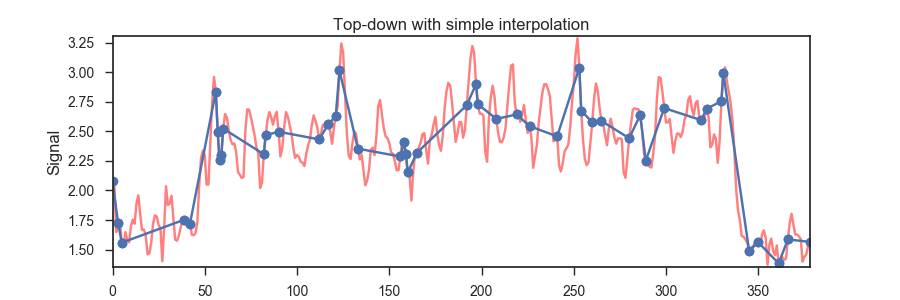

In [84]:
plt.figure()
draw_plot(data_copy, "Top-down with simple interpolation")
draw_segments(segments)

In [85]:
new_segments = []
for s in segments:
    mean = np.mean([s[1], s[3]])
    new_segments.append([s[0], mean, s[2], mean])
    
new_series = create_series(new_segments, data)

In [86]:
change_points = util.get_change_points(new_series)
len(change_points), change_points

(47, array([  0,   3,   5,  39,  42,  56,  57,  58,  59,  60,  82,  83,  90,
        112, 117, 121, 123, 133, 156, 158, 159, 160, 165, 192, 197, 198,
        208, 219, 226, 241, 253, 254, 260, 265, 280, 286, 289, 299, 319,
        322, 330, 331, 345, 350, 361, 366, 378]))

<IPython.core.display.Javascript object>


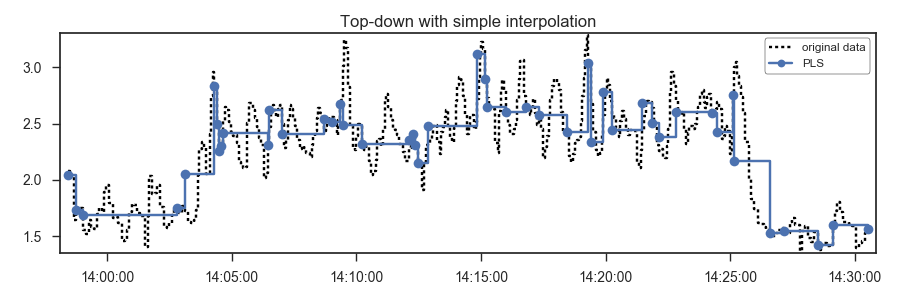

In [87]:
plt.figure()
plt.title("Top-down with simple interpolation")
plt.plot(data, 'k:', label='original data', drawstyle='steps-post')
plt.plot(new_series[change_points], 'o-', label='PLS', drawstyle='steps-post')

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"))
plt.legend(frameon=True, loc='best')
plt.tight_layout()

In [88]:
mse = np.sqrt(((new_series - data) ** 2).mean())
corr = new_series[change_points].corr(data)

mse_dict.update({"top-down with \nsimple interpolation": [mse]})
corr_dict.update({"top-down with \nsimple interpolation": [corr]})

mse, corr

(0.22343704032552969, 0.89955685523653972)

In [89]:
change_points = util.get_change_points(new_series)
n_segments.update({"top-down with \nsimple interpolation": [len(change_points)-1]})
len(change_points)-1

46

# Running Time

In [90]:
from timeseries import benchmark as bm

In [91]:
#sliding window with regression
runtime = %timeit -o -n3 bm.call(segment.slidingwindowsegment, data_copy, fit.regression, fit.sumsquared_error_regr, max_error)

running_time.update({"sliding window \nwith regression": [runtime.best]})

runtime

3 loops, best of 3: 582 ms per loop


<TimeitResult : 3 loops, best of 3: 582 ms per loop>

In [92]:
#bottom-up with regression
runtime = %timeit -o -n3 bm.call(segment.bottomupsegment, data_copy, fit.regression, fit.sumsquared_error_regr, max_error)
running_time.update({"bottom-up with \nregression": [runtime.best]})

runtime

3 loops, best of 3: 1.38 s per loop


<TimeitResult : 3 loops, best of 3: 1.38 s per loop>

In [93]:
#top-down with regression
runtime = %timeit -o -n3 bm.call(segment.topdownsegment, data_copy, fit.regression, fit.sumsquared_error_regr, max_error)
running_time.update({"top-down \nwith regression": [runtime.best]})

runtime

3 loops, best of 3: 5.72 s per loop


<TimeitResult : 3 loops, best of 3: 5.72 s per loop>

In [94]:
#sliding window with simple interpolation
runtime = %timeit -o -n3 bm.call(segment.slidingwindowsegment, data_copy, fit.interpolate, fit.sumsquared_error_int, max_error)
running_time.update({"sliding window with \nsimple interpolation": [runtime.best]})

runtime

3 loops, best of 3: 228 ms per loop


<TimeitResult : 3 loops, best of 3: 228 ms per loop>

In [95]:
#bottom-up with  simple interpolation
runtime = %timeit -o -n3 bm.call(segment.bottomupsegment, data_copy, fit.interpolate, fit.sumsquared_error_int, max_error)
running_time.update({"bottom-up with \nsimple interpolation": [runtime.best]})

runtime

3 loops, best of 3: 611 ms per loop


<TimeitResult : 3 loops, best of 3: 611 ms per loop>

In [96]:
#top-down with  simple interpolation
runtime = %timeit -o -n3 bm.call(segment.topdownsegment, data_copy, fit.interpolate, fit.sumsquared_error_int, max_error)
running_time.update({"top-down with \nsimple interpolation": [runtime.best]})

runtime

3 loops, best of 3: 2.72 s per loop


<TimeitResult : 3 loops, best of 3: 2.72 s per loop>

In [97]:
step = sum(df.duration)//60 # split each 60 seconds
paa_index = data.index[::step]
paa_size = len(paa_index)
paa_size

runtime = %timeit -o -n3 bm.call_paa(data_copy, paa_size)
running_time.update({"paa": [runtime.best]})

runtime

3 loops, best of 3: 21.2 ms per loop


<TimeitResult : 3 loops, best of 3: 21.2 ms per loop>

In [98]:
running_time

{'anba gvf': [1.2330427872588903],
 'anba n': [0.5459032447802588],
 'bottom-up with \nregression': [1.3758478713236098],
 'bottom-up with \nsimple interpolation': [0.6108871209051282],
 'paa': [0.02116408223004858],
 'sliding window \nwith regression': [0.5818803892300034],
 'sliding window with \nsimple interpolation': [0.22779910814281834],
 'top-down \nwith regression': [5.717680008617634],
 'top-down with \nsimple interpolation': [2.719578368359597]}

# PAA

In [99]:
from timeseries import paa

In [100]:
step = sum(df.duration)//30 # split each 60 seconds
paa_index = data.index[::step]
paa_size = len(paa_index)
print(paa_size)
data.index[::step]

6


DatetimeIndex(['2015-10-24 13:58:26', '2015-10-24 14:04:57',
               '2015-10-24 14:09:51', '2015-10-24 14:14:51',
               '2015-10-24 14:19:36', '2015-10-24 14:24:21'],
              dtype='datetime64[ns]', freq=None)

In [101]:
paa_data = paa.paa(data_copy, paa_size)

segment_length = int(len(data)/paa_size)
new_paa = np.array([[x]*segment_length for x in paa_data]).flatten()

if len(new_paa) < len(data):
    missing_len = len(data) - len(new_paa)
    last_points = [paa_data[-1]] * missing_len
    new_paa = np.append(new_paa, last_points)
    
paa_series = pnd.Series(new_paa, index=data.index)

# reintroduce stops
paa_series[data[data==0].index] = 0

#reintroduce noise
paa_series[noise_indexes] = None

In [102]:
change_points = util.get_change_points(paa_series)
len(change_points), change_points

(7, array([  0,  63, 126, 189, 252, 315, 378]))

<IPython.core.display.Javascript object>


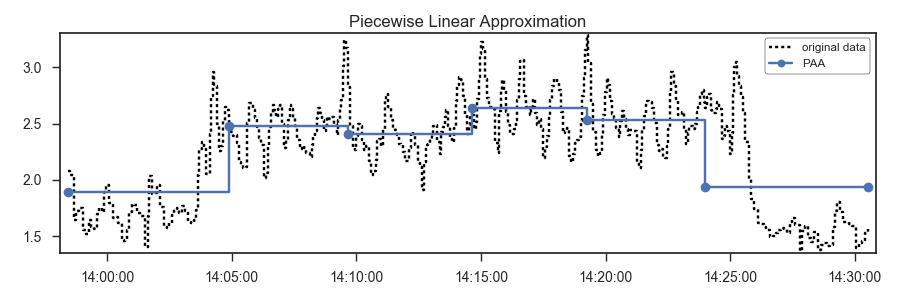

In [103]:
plt.figure()
plt.title("Piecewise Linear Approximation")
plt.plot(data, 'k:', label='original data', drawstyle='steps-post')
plt.plot(paa_series[change_points], 'o-', label='PAA', drawstyle='steps-post')

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"))
plt.legend(frameon=True, loc='best')
plt.tight_layout()

In [104]:
mse = np.sqrt((paa_series[change_points] - data) ** 2).mean()
corr = paa_series[change_points].corr(data)

mse_dict.update({"paa": [mse]})
corr_dict.update({"paa": [corr]})

mse, corr

(0.36030836301350094, 0.66417097306921347)

In [105]:
change_points = util.get_change_points(paa_series)
n_segments.update({"paa": [len(change_points)-1]})
len(change_points)-1

6

In [106]:
#http://docs.astropy.org/en/stable/stats/lombscargle.html
#https://www.youtube.com/watch?v=E4NMZyfao2c
#gatspy

# Graphics

## Mean Squared Error

In [107]:
mean_squared_error = pnd.DataFrame(mse_dict)
mean_squared_error = mean_squared_error.transpose()
#mean_squared_error = mean_squared_error.reset_index()
mean_squared_error['method'] = mean_squared_error.index.values
mean_squared_error.columns = ['mse', 'method']
mean_squared_error.sort_values('mse', inplace=True)

In [108]:
relative = []
for row in mean_squared_error.itertuples():
    relative.append((row.mse/min(mean_squared_error.mse)))

mean_squared_error['relative'] = pnd.Series(relative, index=mean_squared_error.index)

<IPython.core.display.Javascript object>


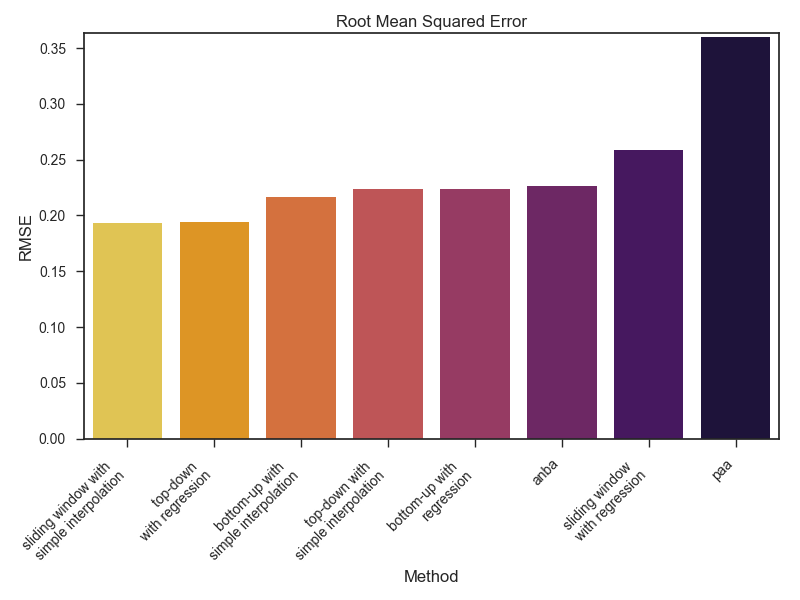

In [109]:
plt.figure(figsize=(8, 6))
plt.title("Root Mean Squared Error")
plt.xticks(label=mean_squared_error.method, rotation=45, ha='right')
sns.barplot(x='method', y='mse', data=mean_squared_error, palette='inferno_r')
plt.xlabel("Method")
plt.ylabel("RMSE")
plt.gca().set_ylim(0)
plt.tight_layout();

<IPython.core.display.Javascript object>


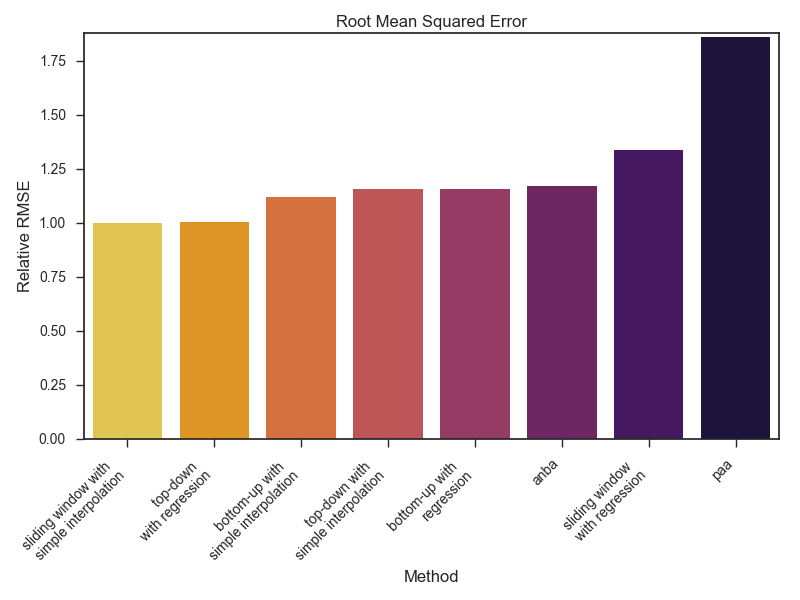

In [110]:
plt.figure(figsize=(8, 6))
plt.title("Root Mean Squared Error")
plt.xticks(label=mean_squared_error.method, rotation=45, ha='right')
sns.barplot(x='method', y='relative', data=mean_squared_error, palette='inferno_r')
plt.xlabel("Method")
plt.ylabel("Relative RMSE")
plt.gca().set_ylim(0)
plt.tight_layout();

## Correlation

In [111]:
correlation = pnd.DataFrame(corr_dict)
correlation = correlation.transpose()
#correlation = correlation.reset_index()
correlation['method'] = correlation.index.values
correlation.columns = ['correlation', 'method']

correlation.sort_values('correlation', ascending=False, inplace=True)

In [112]:
relative = []
for row in correlation.itertuples():
    relative.append((row.correlation/max(correlation.correlation)))

correlation['relative'] = pnd.Series(relative, index=correlation.index)
correlation

,correlation,method,relative
top-down with \nsimple interpolation,0.899557,top-down with \nsimple interpolation,1.000000
bottom-up with \nregression,0.858641,bottom-up with \nregression,0.954515
top-down \nwith regression,0.818819,top-down \nwith regression,0.910247
sliding window with \nsimple interpolation,0.787128,sliding window with \nsimple interpolation,0.875017
anba,0.769298,anba,0.855196
bottom-up with \nsimple interpolation,0.728104,bottom-up with \nsimple interpolation,0.809403
paa,0.664171,paa,0.738331
sliding window \nwith regression,0.623819,sliding window \nwith regression,0.693474


<IPython.core.display.Javascript object>


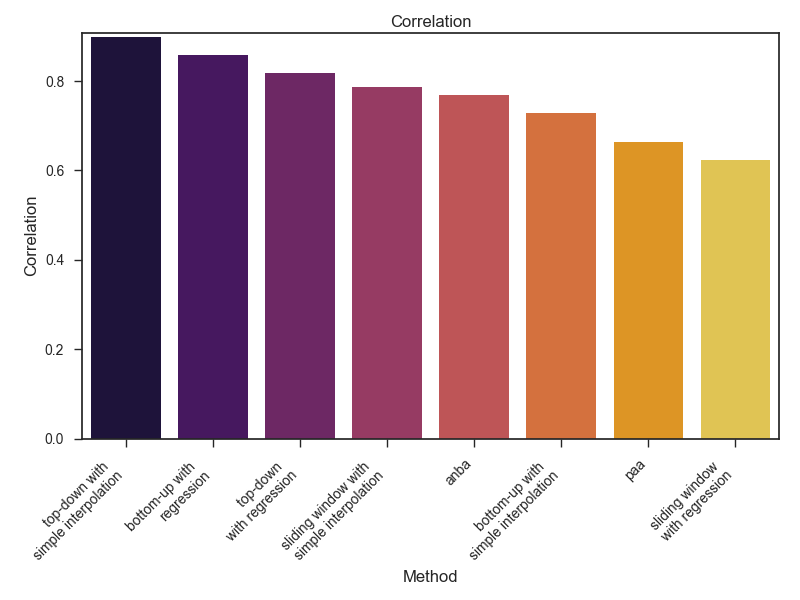

In [113]:
plt.figure(figsize=(8, 6))
plt.title("Correlation")
plt.xticks(label=correlation.method, rotation=45, ha='right')
sns.barplot(x='method', y='correlation', data=correlation, palette='inferno')
plt.xlabel("Method")
plt.ylabel("Correlation")
plt.gca().set_ylim(0)
plt.tight_layout();

<IPython.core.display.Javascript object>


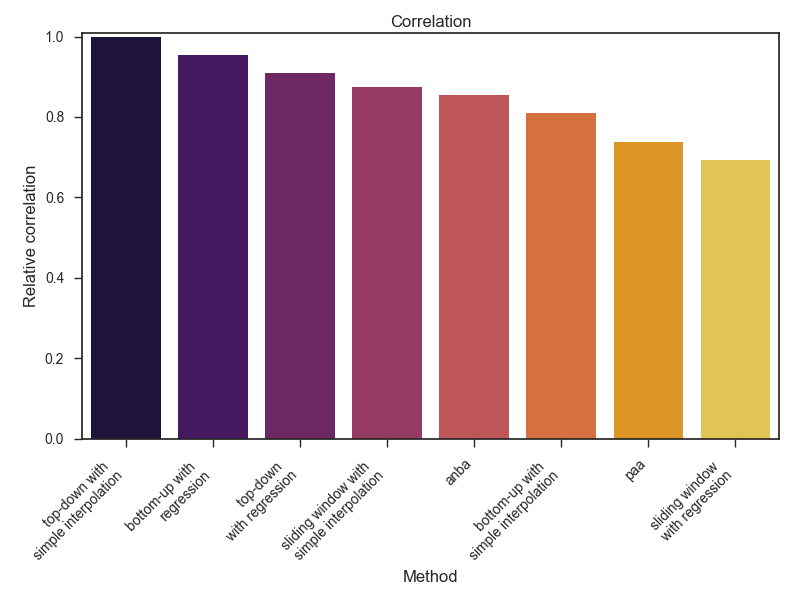

In [114]:
plt.figure(figsize=(8, 6))
plt.title("Correlation")
plt.xticks(label=correlation.method, rotation=45, ha='right')
sns.barplot(x='method', y='relative', data=correlation, palette='inferno')
plt.xlabel("Method")
plt.ylabel("Relative correlation")
plt.gca().set_ylim(0)
plt.tight_layout();

## Running time

In [115]:
run = pnd.DataFrame(running_time)
run = run.transpose()
#run = run.reset_index()
run['method'] = run.index.values
run.columns = ['time', 'method']
run.sort_values('time', inplace=True)

In [116]:
relative = []
for row in run.itertuples():
    relative.append((row.time/min(run.time)))

run['relative'] = pnd.Series(relative, index=run.index)

In [117]:
run

,time,method,relative
paa,0.021164,paa,1.000000
sliding window with \nsimple interpolation,0.227799,sliding window with \nsimple interpolation,10.763477
anba n,0.545903,anba n,25.793854
sliding window \nwith regression,0.581880,sliding window \nwith regression,27.493769
bottom-up with \nsimple interpolation,0.610887,bottom-up with \nsimple interpolation,28.864333
anba gvf,1.233043,anba gvf,58.261104
bottom-up with \nregression,1.375848,bottom-up with \nregression,65.008624
top-down with \nsimple interpolation,2.719578,top-down with \nsimple interpolation,128.499707
top-down \nwith regression,5.717680,top-down \nwith regression,270.159601


<IPython.core.display.Javascript object>


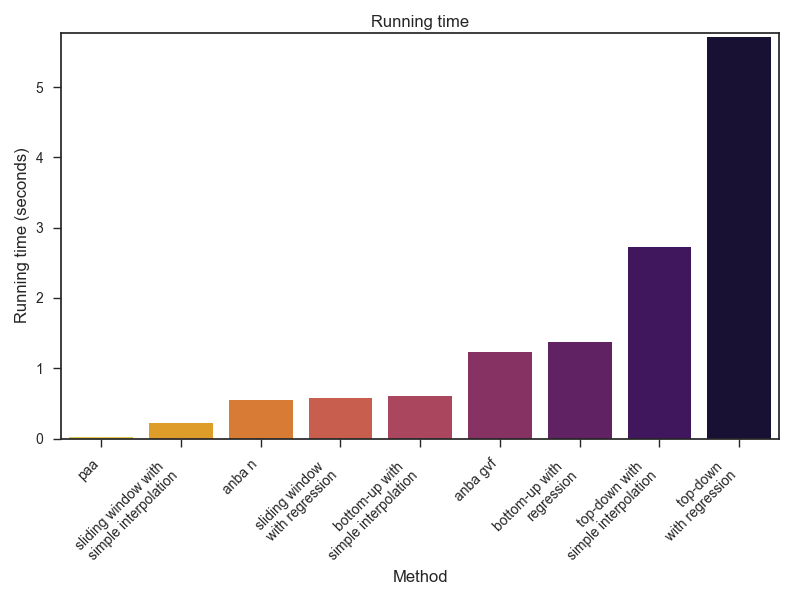

In [118]:
plt.figure(figsize=(8, 6))
plt.title("Running time")
plt.xticks(label=run.method, rotation=45, ha='right')
sns.barplot(x='method', y='time', data=run, palette='inferno_r')
plt.xlabel("Method")
plt.ylabel("Running time (seconds)")
#plt.gca().set_ylim(0)
plt.tight_layout();

<IPython.core.display.Javascript object>


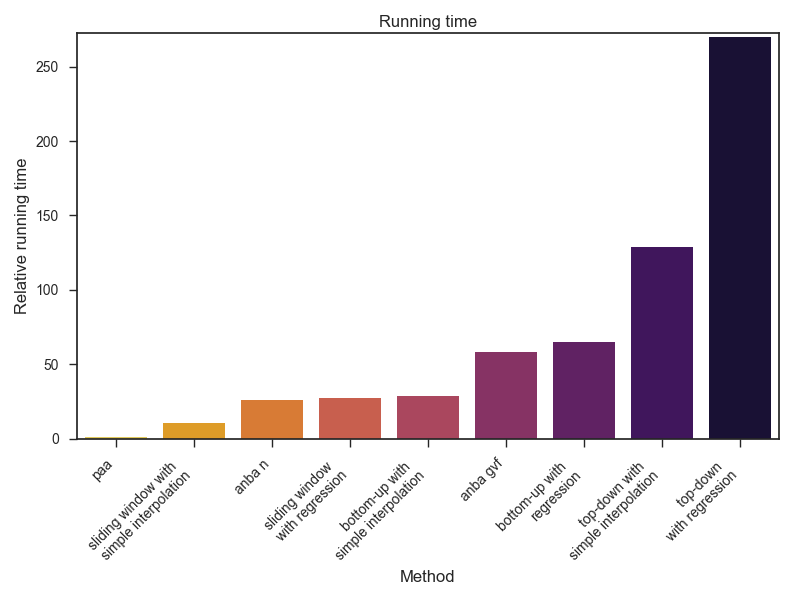

In [119]:
plt.figure(figsize=(8, 6))
plt.title("Running time")
plt.xticks(label=run.method, rotation=45, ha='right')
sns.barplot(x='method', y='relative', data=run, palette='inferno_r')
plt.xlabel("Method")
plt.ylabel("Relative running time")
#plt.gca().set_ylim(0)
plt.tight_layout();

## Number of segments

In [120]:
n_seg = None
n_seg = pnd.DataFrame(n_segments)
n_seg = n_seg.transpose()
#n_seg = n_seg.reset_index()
n_seg['method'] = n_seg.index.values
n_seg.columns = ['n_segments', 'method']
n_seg.sort_values('n_segments', inplace=True)

In [121]:
relative = []
for row in n_seg.itertuples():
    relative.append(row.n_segments/min(n_seg.n_segments))

n_seg['relative'] = pnd.Series(relative, index=n_seg.index)

In [122]:
n_seg

,n_segments,method,relative
paa,6,paa,1.000000
anba,7,anba,1.166667
bottom-up with \nregression,13,bottom-up with \nregression,2.166667
sliding window \nwith regression,15,sliding window \nwith regression,2.500000
bottom-up with \nsimple interpolation,20,bottom-up with \nsimple interpolation,3.333333
top-down \nwith regression,20,top-down \nwith regression,3.333333
sliding window with \nsimple interpolation,26,sliding window with \nsimple interpolation,4.333333
top-down with \nsimple interpolation,46,top-down with \nsimple interpolation,7.666667


<IPython.core.display.Javascript object>


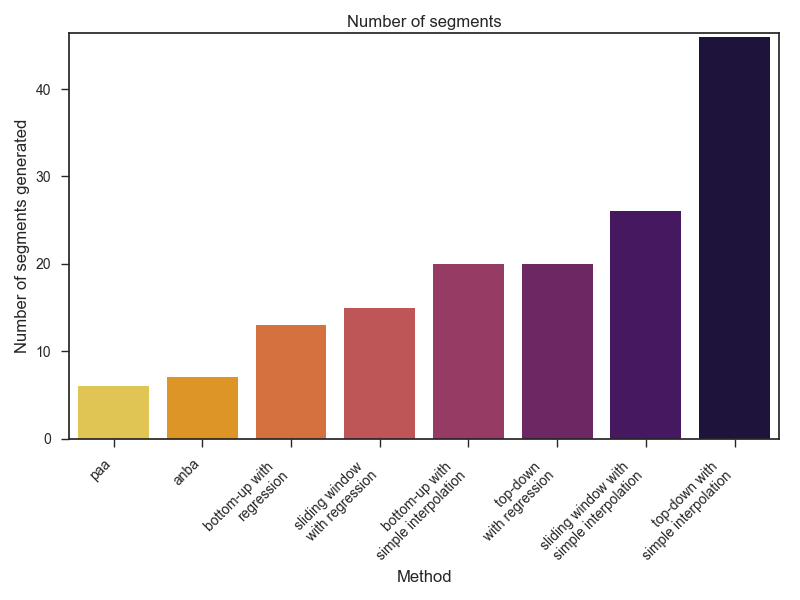

In [123]:
plt.figure(figsize=(8, 6))
plt.title("Number of segments")
plt.xticks(label=run.method, rotation=45, ha='right')
sns.barplot(x='method', y='n_segments', data=n_seg, palette='inferno_r')
plt.xlabel("Method")
plt.ylabel("Number of segments generated")
plt.gca().set_ylim(0)
plt.tight_layout();

<IPython.core.display.Javascript object>


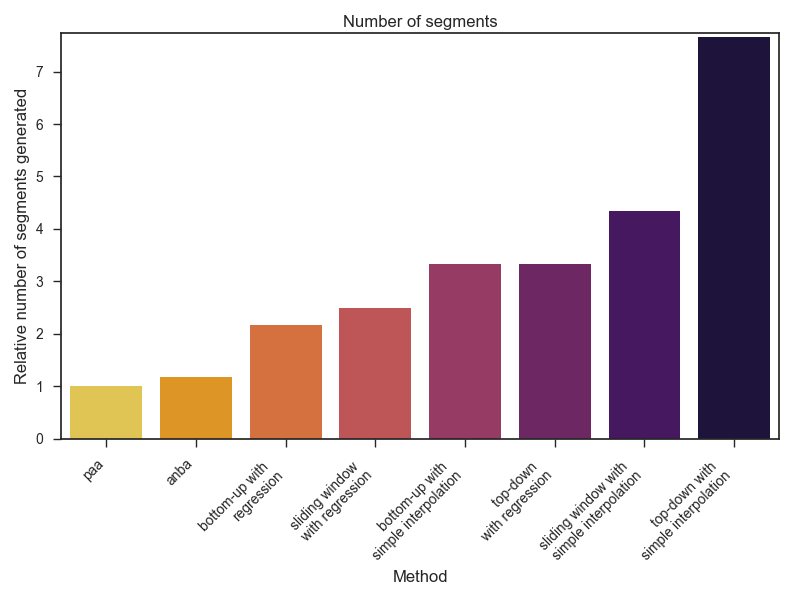

In [124]:
plt.figure(figsize=(8, 6))
plt.title("Number of segments")
plt.xticks(label=run.method, rotation=45, ha='right')
sns.barplot(x='method', y='relative', data=n_seg, palette='inferno_r')
plt.xlabel("Method")
plt.ylabel("Relative number of segments generated")
plt.gca().set_ylim(0)
plt.tight_layout();

## Correlation x Number of segments x Running time

In [125]:
run2 = run[run.method != 'anba n']
run2.replace('anba gvf', 'anba', inplace=True)
run2.set_index("method", inplace=True)
run2.drop(['relative'], 1, inplace=True)
run2.index.name = None

c:\users\tales\anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\users\tales\anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [126]:
corr_seg = pnd.concat([correlation, n_seg.n_segments, run2.time], axis=1)
corr_seg.drop('relative', 1, inplace=True)

plt.figure(figsize=(12, 9))
plt.scatter(corr_seg.correlation, corr_seg.n_segments, c=corr_seg.time, s=100, cmap=cm.inferno_r);
plt.colorbar(label='best time')

plt.xlabel("Correlation")
plt.ylabel("Number of segments")

plt.ylim(ymin=0)

ax = plt.gca()
for row in corr_seg.itertuples():
    ax.annotate("{0}\n{1:.3f}s".format(row.method, row.time), (row.correlation+.01, row.n_segments-0.05), color='k');
    

<IPython.core.display.Javascript object>


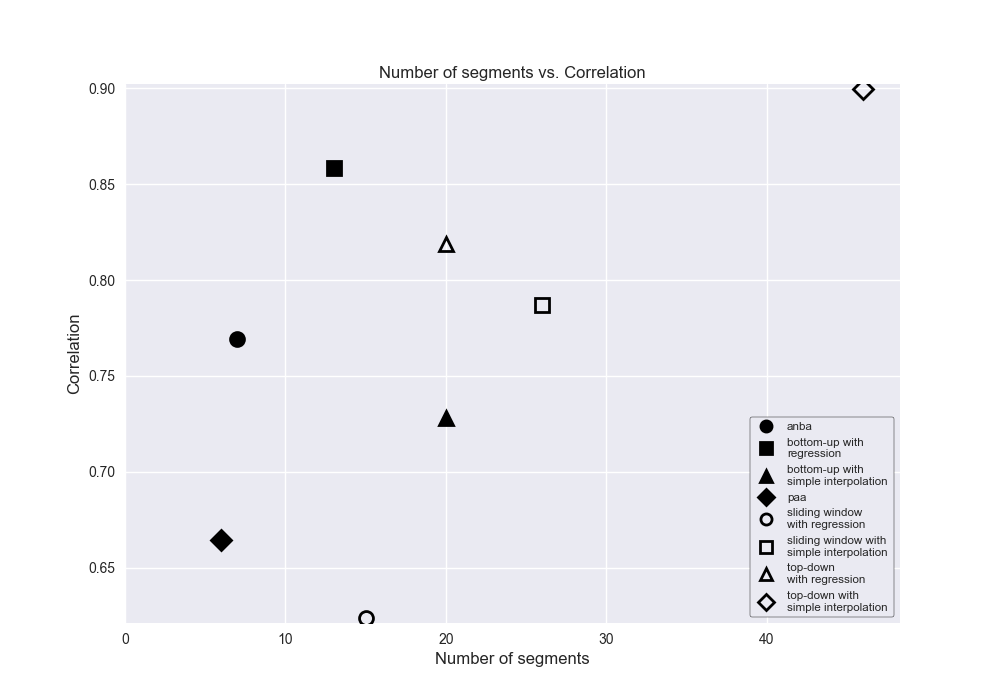

In [127]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 7))
    plt.ylabel("Correlation")
    plt.xlabel("Number of segments")
    plt.title("Number of segments vs. Correlation")

    plt.xlim(xmin=0, xmax=max(corr_seg.n_segments)*1.05)

    markers_styles = [('full', 'none'), ('os^D')]
    marker_style = itertools.cycle(list(itertools.product(*markers_styles)))

    for tup in corr_seg.itertuples():
        fill, mark = next(marker_style)
        plt.plot([tup.n_segments], [tup.correlation], marker=mark, 
                 fillstyle=fill, color='k', label=tup.Index, mew=2, lw=0, ms=10)

    plt.legend(frameon=True, loc=4); #loc=2